In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
cuda=True

In [3]:
##########read data separate by <start> and <end>
#########file represent the input file, batch represent batch size 
#########read_file is only used to read the data line by line in the tune

def read_file(file):
    with open(file,'r') as f:
        one_set=[]
        data=[]
        #line=readline(f)
        for l in f:
            '''
            if l.rstrip()=='<start>':  #####start index, we won't read <start> and <end> index
                continue
            '''
            one_set.append(l)
            if l.rstrip()=='<end>':  ####end of a set
                data.append(one_set)
                one_set=[]
                continue            
        return data
'''
seperate_data_hb is used to seperate the data into header part and body part 
'''
def seperate_data_hb(data):
    header=[]
    body=[]
    for d in data:
        head_set=[]
        body_set=[]
        for item in d:
            #########if it's <start>\r\n or the second character is : then it's header
            if item=='<start>\r\n' or item[1]==':':
                head_set.append(item)
            else:
                body_set.append(item)
        header.append(head_set)
        body.append(body_set)
    return header,body
'''
generate_data is used to get the character from original data file

seperate_data(data,batch) is used to get the character from batch to batch
data represent the data set we get from read_file
batch represent the batch size
'''
###########here is the function for a rough model, here we generate all the data together
def generate_data(data):
    data_set=[]
    ############put all character together
    for d in data:
        for item in d:
            char=list(item)
            data_set.extend(char)
    return data_set

def separate_data(data,batch):
    data_set=[]
    i=0
    while i+batch<len(data):
        data_set.append(data[i:i+batch])
        i+=batch
    '''
    if i<len(data):
        empty=['' for j in range(i+batch-len(data))]
        target=data[i:len(data)]
        target.extend(empty)
        data_set.append(target)
    '''
    data_set.append(data[i:len(data)])
    return data_set
'''
get_dict function is used to get the classes in the input file
classes represent the character, dict_data represent the index we gave for each character
matric_data represent the hot vector for each character
'''
def get_dict(data):
    data=list(set(data))
    dict_char={}
    dict_num={}
    matrix_data=[[0 for i in range(len(data))] for j in range(len(data))]
    num=0
    for d in data:
        dict_char[d]=num         #######use character as index
        dict_num[num]=d          #######use the number as index
        matrix_data[num][num]=1
        num+=1
    return dict_char,dict_num,matrix_data

In [4]:
input_data=read_file('input.txt')

In [5]:
char2idx,idx2char,class_matrix=get_dict(generate_data(input_data))

In [6]:
##############seperate to training(80%) and validation(20%) set
t=int(len(input_data)*0.8)
train_data=generate_data(input_data[:t])
vali_data=generate_data(input_data[t:])

In [7]:
#######here batch size is 30 but we may need to change it to increase the accuracy 
train_batch=separate_data(train_data,20)
vali_batch=separate_data(vali_data,20)

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

class Net(nn.Module):
    #####the layer should cntain the size for each layer including input and output
    #####the form of layer should like [1,....,size of class]
    def __init__(self, dropout=0, hidden_size=100, num_layers=1, Embedding_size=len(char2idx),type_model='LSTM'):
        super(Net, self).__init__()
        
        self.word_embeddings = nn.Embedding(len(char2idx), Embedding_size)

#         layers=[]
#         for l in range(len(layer)):
#             if l+2==len(layer):
#                 break
#             layers.append(nn.GRU(input_size=layer[l],
#                             hidden_size=layer[l+1],
#                             num_layers=1))
#         self.rnn=nn.Sequential(*layers)
        if type_model=="LSTM":
            self.rnn=nn.LSTM(input_size=len(char2idx),
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        dropout=dropout)
        else:
            self.rnn=nn.GRU(input_size=len(char2idx),
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        dropout=dropout)
        
        self.dense1 = nn.Linear(hidden_size,94)
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.type_model=type_model
        self.init_hidden()
        
    def forward(self, sequence):
        sequence=var(torch.LongTensor([char2idx[x] for x in sequence]))   ####get the index for character x
        embeds = self.word_embeddings(sequence)
        #x, self.hidden = self.rnn(embeds.view(len(sequence), 1, -1), self.hidden)
        x, new_hidden = self.rnn(embeds.view(len(sequence), 1, -1), self.hidden)
        x = x.view(-1, self.hidden_size)
        x = self.dense1(x)
        return x,new_hidden

    def init_hidden(self):
        if self.type_model=="LSTM":
            self.hidden = (Variable(torch.zeros(self.num_layers,1,self.hidden_size).cuda())
                        ,Variable(torch.zeros(self.num_layers,1,self.hidden_size).cuda()))
        else:
            self.hidden = Variable(torch.zeros(self.num_layers,1,self.hidden_size).cuda())

def var(x):
    x = Variable(x)
    if cuda:
        return x.cuda()
    else:
        return x

In [51]:
import random
from random import *
from datetime import datetime
seed(datetime.now())

from torch.autograd import Variable
def generate(starts, idx2char, predictLen, temperature, model):
    if len(starts) > 0:
        heat_map1=[]
        heat_map2=[]
        for count in range(predictLen):
            accWeight = []
            ## assume nextLetter is the best predicted vector of letter after alg.
            output,new_hidden = model(starts)
            output = F.softmax(torch.div(output, temperature))
            ########################get data from hidden layer to heatmap
            heat_map1.append(new_hidden[0].data[0][0])
            heat_map2.append(new_hidden[1].data[0][0])
            nextLetter = list((output[-1]).data)
            #print(nextLetter)
            accWeight = np.cumsum(nextLetter)
            #print(accWeight[0])
            #break
            prob = random()
            for i in range(len(idx2char)):           
                if (accWeight[i] >= prob):
                    starts += idx2char[i]
#                     res.append(idx2char[i])
                    break
#             starts += idx2char[i]
            l = len(starts)
            if (l >= 5):
                if  (starts[l - 1] == '>' and
                    starts[l - 2] == 'd' and
                    starts[l - 3] == 'n' and
                    starts[l - 4] == 'e' and
                    starts[l - 5] == '<'):
                    break
    return starts,heat_map1,heat_map2

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


def train(model, train_batch, vali_batch, optimizer, maxIteration=1000, cuda=True):
    
    criterion = nn.CrossEntropyLoss()
    train_result =[[],[]] # train_result[0]: loss; train_result[1]: accuracy
    vali_result =[[], []] # same as above
    for epoch in range(maxIteration):
        running_loss = 0
        running_acc = 0
        
        start = time.time()
        for minibatch in train_batch:
            

            
            """forward"""
            x, labels = minibatch[:-1], minibatch[1:]
            y, new_hidden = model(x)
            _, preds = torch.max(y.data, 1)
            labels = var(torch.LongTensor([char2idx[label] for label in labels]))
            
            """backprop"""
            loss = criterion(y, labels)
            loss.backward(retain_graph=False)
            optimizer.step()
            
            running_loss += loss.data[0]
            running_acc += torch.sum(preds == labels.data)
            
        end = time.time()
        
        """training loss and accuracy"""
        running_loss /= len(train_batch)
        running_acc /= 436567.
        train_result[0].append(running_loss)
        train_result[1].append(running_acc)
        
        """validation loss and accuracy"""
        vali_loss, vali_acc = evaluate(model, criterion, vali_batch)
        vali_result[0].append(vali_loss)
        vali_result[1].append(vali_acc)
        
        """print reuslts"""
        print('epoch[%s], time: %.3f, train loss: %.5f, train acc: %.5f, val loss: %.5f, val acc:%.5f' %
              (epoch, end-start, running_loss, running_acc, vali_loss, vali_acc))
        
        ############whenit keep increasing, break
        
        if epoch>6 and vali_result[0][-1] > vali_result[0][-5]:
            break
        
    x = range(len(train_result[0]))
    plt.figure(0)
    plt.ylabel('Loss', fontsize=20)
    plt.plot(x, train_result[0], label='train')
    plt.plot(x, vali_result[0], label='valid')
    print('final loss: ', train_result[0][-1], vali_result[0][-1])
    plt.legend()
    plt.grid()
    
    plt.figure(1)
    plt.ylabel('Accuracy', fontsize=20)
    plt.plot(x, train_result[1], label='train')
    plt.plot(x, vali_result[1], label='valid')
    print('final acc: ', train_result[1][-1], vali_result[1][-1])
    plt.legend()
    plt.grid()
    
    plt.show()

def evaluate(model, criterion, vali_batch):
    running_loss = 0
    running_acc = 0
    for minibatch in vali_batch:
        x, labels = minibatch[:-1], minibatch[1:]
        y,hidden = model(x)
        _, preds = torch.max(y.data, 1)
        labels = var(torch.LongTensor([char2idx[label] for label in labels]))
        loss = criterion(y, labels)
        running_loss += loss.data[0]
        running_acc += torch.sum(preds == labels.data)
    return running_loss/len(vali_batch), running_acc/83613.

epoch[0], time: 42.115, train loss: 3.38526, train acc: 0.19898, val loss: 2.80014, val acc:0.23578
epoch[1], time: 42.479, train loss: 2.76827, train acc: 0.26883, val loss: 2.51212, val acc:0.28722
epoch[2], time: 40.713, train loss: 2.50699, train acc: 0.31799, val loss: 2.34981, val acc:0.32985
epoch[3], time: 39.976, train loss: 2.33031, train acc: 0.35489, val loss: 2.25966, val acc:0.34931
epoch[4], time: 45.047, train loss: 2.22558, train acc: 0.38228, val loss: 2.20015, val acc:0.36000
epoch[5], time: 43.848, train loss: 2.14847, train acc: 0.40304, val loss: 2.17052, val acc:0.37208
epoch[6], time: 43.047, train loss: 2.10497, train acc: 0.41518, val loss: 2.16909, val acc:0.37287
epoch[7], time: 44.890, train loss: 2.07102, train acc: 0.42611, val loss: 2.15248, val acc:0.37713
epoch[8], time: 40.173, train loss: 2.04200, train acc: 0.43276, val loss: 2.14651, val acc:0.38135
epoch[9], time: 44.203, train loss: 2.02037, train acc: 0.43933, val loss: 2.14821, val acc:0.38255


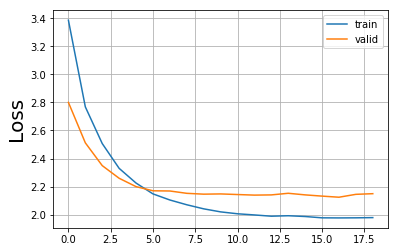

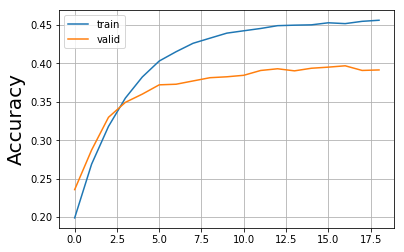

In [17]:
################initialize model
#######initial value self, dropout=0, hidden_size=100, num_layers=1, Embedding_size=len(char2idx),type_model='LSTM'
############here we test the plot when hidden_size=75 num_layers=1
model = Net(hidden_size=75,num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

epoch[0], time: 59.047, train loss: 3.56387, train acc: 0.14348, val loss: 3.15213, val acc:0.19917
epoch[1], time: 62.220, train loss: 3.13043, train acc: 0.19353, val loss: 2.85787, val acc:0.21330
epoch[2], time: 61.748, train loss: 2.86644, train acc: 0.24224, val loss: 2.64631, val acc:0.26306
epoch[3], time: 60.839, train loss: 2.68239, train acc: 0.28026, val loss: 2.51156, val acc:0.29316
epoch[4], time: 64.876, train loss: 2.53956, train acc: 0.30175, val loss: 2.39596, val acc:0.32232
epoch[5], time: 57.680, train loss: 2.41643, train acc: 0.33352, val loss: 2.28939, val acc:0.34739
epoch[6], time: 60.280, train loss: 2.33281, train acc: 0.35117, val loss: 2.22880, val acc:0.35143
epoch[7], time: 61.716, train loss: 2.26028, train acc: 0.36922, val loss: 2.19247, val acc:0.35108
epoch[8], time: 60.235, train loss: 2.20002, train acc: 0.38674, val loss: 2.16383, val acc:0.36277
epoch[9], time: 58.261, train loss: 2.14994, train acc: 0.39768, val loss: 2.14399, val acc:0.36503


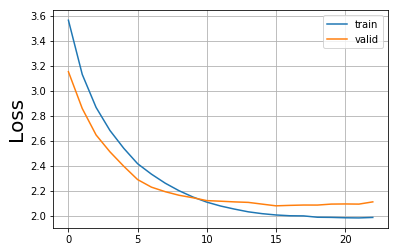

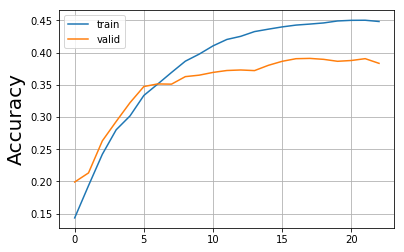

In [18]:
################initialize model
#######initial value self, dropout=0, hidden_size=100, num_layers=1, Embedding_size=len(char2idx),type_model='LSTM'
############here we test the plot when hidden_size=75 num_layers=2
model = Net(hidden_size=75,num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

epoch[0], time: 76.121, train loss: 2.78287, train acc: 0.27257, val loss: 2.30491, val acc:0.31488
epoch[1], time: 84.777, train loss: 2.42043, train acc: 0.34133, val loss: 2.21570, val acc:0.34078
epoch[2], time: 76.782, train loss: 2.26408, train acc: 0.37004, val loss: 2.20059, val acc:0.35398
epoch[3], time: 83.243, train loss: 2.20083, train acc: 0.38722, val loss: 2.18681, val acc:0.35923
epoch[4], time: 85.117, train loss: 2.16786, train acc: 0.39325, val loss: 2.21038, val acc:0.35809
epoch[5], time: 71.632, train loss: 2.15189, train acc: 0.39833, val loss: 2.23171, val acc:0.35313
epoch[6], time: 75.875, train loss: 2.14396, train acc: 0.40433, val loss: 2.24418, val acc:0.35148
epoch[7], time: 76.491, train loss: 2.14559, train acc: 0.40386, val loss: 2.26155, val acc:0.35814
epoch[8], time: 71.310, train loss: 2.15324, train acc: 0.40523, val loss: 2.29441, val acc:0.35268
epoch[9], time: 85.509, train loss: 2.15391, train acc: 0.40497, val loss: 2.30335, val acc:0.36217


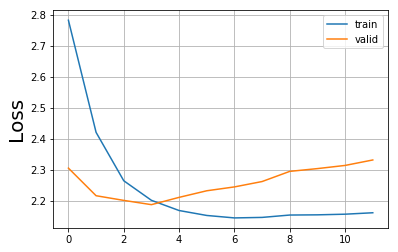

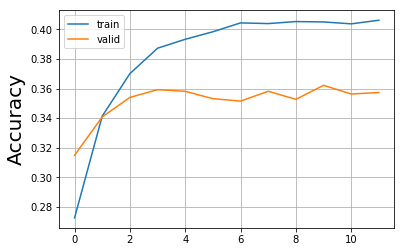

In [11]:
################initialize model
#######initial value self, dropout=0, hidden_size=100, num_layers=1, Embedding_size=len(char2idx),type_model='LSTM'
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

epoch[0], time: 64.388, train loss: 3.10567, train acc: 0.22044, val loss: 2.55986, val acc:0.27447
epoch[1], time: 66.999, train loss: 2.66965, train acc: 0.28088, val loss: 2.41371, val acc:0.30824
epoch[2], time: 64.071, train loss: 2.45413, train acc: 0.32125, val loss: 2.29784, val acc:0.33770
epoch[3], time: 65.471, train loss: 2.28205, train acc: 0.36022, val loss: 2.23161, val acc:0.35500
epoch[4], time: 65.386, train loss: 2.21070, train acc: 0.38800, val loss: 2.21178, val acc:0.36497
epoch[5], time: 64.594, train loss: 2.16162, train acc: 0.39504, val loss: 2.23196, val acc:0.35175
epoch[6], time: 68.770, train loss: 2.13616, train acc: 0.40910, val loss: 2.21755, val acc:0.36962
epoch[7], time: 62.355, train loss: 2.13520, train acc: 0.41127, val loss: 2.25894, val acc:0.36716
epoch[8], time: 65.660, train loss: 2.12131, train acc: 0.41720, val loss: 2.24097, val acc:0.37151
epoch[9], time: 67.450, train loss: 2.12578, train acc: 0.41578, val loss: 2.28012, val acc:0.36975


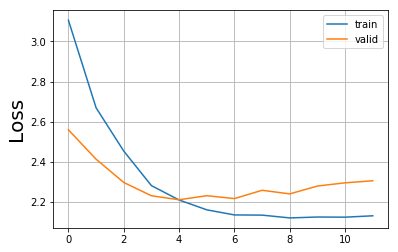

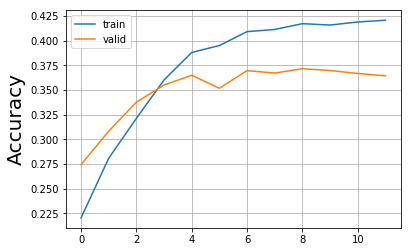

In [25]:
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1 optimizer=RMSprop
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
optimizer_R=optim.RMSprop(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer_R, maxIteration=50, cuda=True)

epoch[0], time: 84.120, train loss: 6.70297, train acc: 0.24484, val loss: 9.98003, val acc:0.18759
epoch[1], time: 83.545, train loss: 17.13151, train acc: 0.17785, val loss: 18.40394, val acc:0.15367
epoch[2], time: 84.903, train loss: 26.97789, train acc: 0.16112, val loss: 27.91560, val acc:0.14981
epoch[3], time: 69.658, train loss: 39.74797, train acc: 0.15081, val loss: 40.28473, val acc:0.13381
epoch[4], time: 77.131, train loss: 53.19769, train acc: 0.14448, val loss: 55.07048, val acc:0.12762
epoch[5], time: 71.397, train loss: 64.20521, train acc: 0.14080, val loss: 60.96190, val acc:0.14463
epoch[6], time: 73.392, train loss: 82.50386, train acc: 0.13121, val loss: 81.24937, val acc:0.13345
epoch[7], time: 73.373, train loss: 95.51204, train acc: 0.13927, val loss: 99.09011, val acc:0.12272
epoch[8], time: 82.730, train loss: 108.84129, train acc: 0.14057, val loss: 107.04096, val acc:0.13633
epoch[9], time: 72.800, train loss: 128.14341, train acc: 0.13934, val loss: 127.7

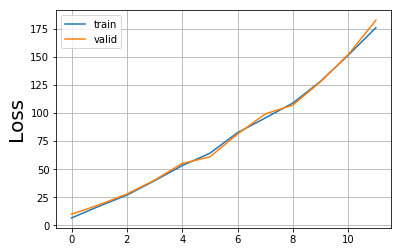

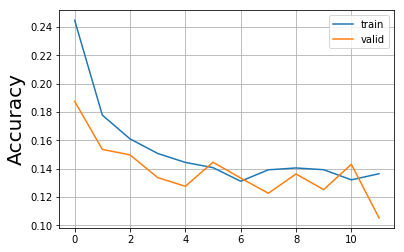

In [12]:
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1 optimizer=RMSprop learning_rate=0.001
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
optimizer_R=optim.RMSprop(model.parameters(), lr=0.001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer_R, maxIteration=50, cuda=True)

epoch[0], time: 92.534, train loss: 2.75164, train acc: 0.28332, val loss: 2.27666, val acc:0.31824
epoch[1], time: 92.432, train loss: 2.39530, train acc: 0.34640, val loss: 2.18797, val acc:0.34841
epoch[2], time: 92.647, train loss: 2.26690, train acc: 0.37104, val loss: 2.20097, val acc:0.36882
epoch[3], time: 93.829, train loss: 2.21410, train acc: 0.38510, val loss: 2.20995, val acc:0.36345
epoch[4], time: 93.934, train loss: 2.16693, train acc: 0.39544, val loss: 2.20531, val acc:0.36498
epoch[5], time: 88.447, train loss: 2.14004, train acc: 0.40450, val loss: 2.18555, val acc:0.36839
epoch[6], time: 95.236, train loss: 2.13624, train acc: 0.40663, val loss: 2.21576, val acc:0.36723
epoch[7], time: 92.417, train loss: 2.13225, train acc: 0.40780, val loss: 2.22720, val acc:0.36351
epoch[8], time: 91.183, train loss: 2.14692, train acc: 0.40494, val loss: 2.26573, val acc:0.35978
epoch[9], time: 91.728, train loss: 2.14770, train acc: 0.40163, val loss: 2.26283, val acc:0.36425


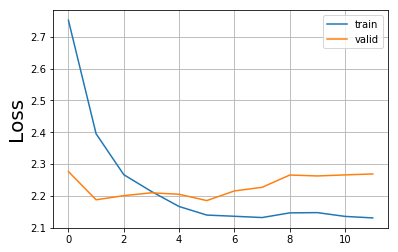

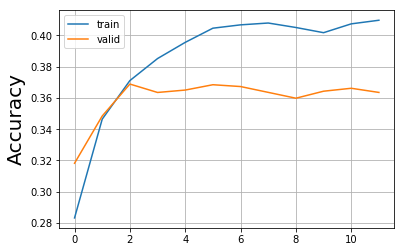

In [12]:
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1 optimizer=Adam batchsize=20
train_batch=separate_data(train_data,20)
vali_batch=separate_data(vali_data,20)
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

epoch[0], time: 28.077, train loss: 3.42057, train acc: 0.18488, val loss: 2.84245, val acc:0.22251
epoch[1], time: 29.221, train loss: 2.81094, train acc: 0.26010, val loss: 2.54529, val acc:0.28060
epoch[2], time: 27.005, train loss: 2.55073, train acc: 0.30773, val loss: 2.35026, val acc:0.32422
epoch[3], time: 27.128, train loss: 2.34921, train acc: 0.35419, val loss: 2.22246, val acc:0.34920
epoch[4], time: 29.328, train loss: 2.21898, train acc: 0.38381, val loss: 2.14525, val acc:0.36535
epoch[5], time: 27.323, train loss: 2.11947, train acc: 0.41340, val loss: 2.08803, val acc:0.37780
epoch[6], time: 29.041, train loss: 2.03421, train acc: 0.43542, val loss: 2.02897, val acc:0.39454
epoch[7], time: 24.145, train loss: 1.97227, train acc: 0.44825, val loss: 1.99016, val acc:0.40573
epoch[8], time: 27.601, train loss: 1.92010, train acc: 0.46182, val loss: 1.96681, val acc:0.41480
epoch[9], time: 27.356, train loss: 1.87926, train acc: 0.46951, val loss: 1.96101, val acc:0.41629


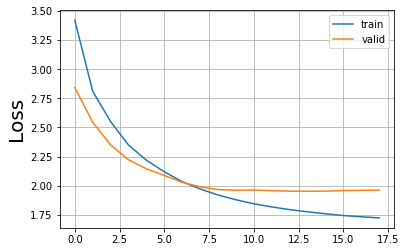

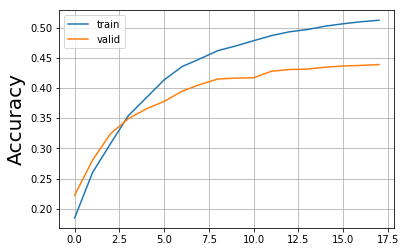

In [13]:
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1 optimizer=Adam batchsize=100
train_batch=separate_data(train_data,100)
vali_batch=separate_data(vali_data,100)
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
if cuda:
    model.cuda()
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

epoch[0], time: 30.107, train loss: 2.63169, train acc: 0.30648, val loss: 2.18842, val acc:0.36835
epoch[1], time: 29.106, train loss: 2.30750, train acc: 0.37137, val loss: 2.11459, val acc:0.37681
epoch[2], time: 30.231, train loss: 2.11943, train acc: 0.40071, val loss: 2.07247, val acc:0.38756
epoch[3], time: 30.096, train loss: 1.93210, train acc: 0.44896, val loss: 1.99165, val acc:0.39704
epoch[4], time: 29.696, train loss: 1.83946, train acc: 0.47505, val loss: 1.90511, val acc:0.42078
epoch[5], time: 28.498, train loss: 1.77327, train acc: 0.48741, val loss: 1.88049, val acc:0.42673
epoch[6], time: 29.272, train loss: 1.72251, train acc: 0.50159, val loss: 1.86053, val acc:0.43646
epoch[7], time: 26.741, train loss: 1.67871, train acc: 0.51227, val loss: 1.83954, val acc:0.44214
epoch[8], time: 26.140, train loss: 1.64363, train acc: 0.51915, val loss: 1.81876, val acc:0.45028
epoch[9], time: 28.238, train loss: 1.61505, train acc: 0.52802, val loss: 1.81173, val acc:0.45369


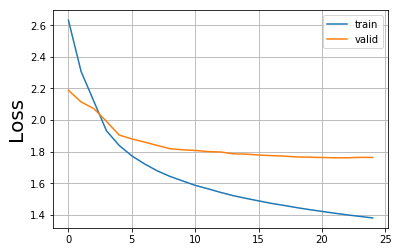

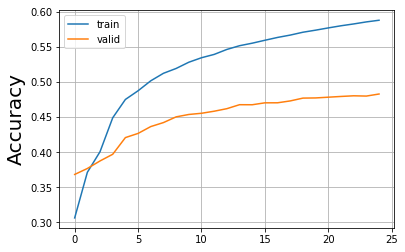

In [14]:
############here we test the plot when hidden_size=150 num_layers=1 dropout=0.1 optimizer=Adagrad batchsize=100 learning rate=0.001
train_batch=separate_data(train_data,100)
vali_batch=separate_data(vali_data,100)
model = Net(dropout=0.1,hidden_size=150,num_layers=1)
if cuda:
    model.cuda()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
train(model, train_batch, vali_batch, optimizer, maxIteration=50, cuda=True)

In [104]:
music,heat_map1,heat_map2=generate('<start>',idx2char,1000,1, model)

In [105]:
print(music)

<start>
X:24
T:Ailto:galouvielle@free.fr
M:2/4
L:1/8
Q:1/4=1150
L:1/8
K:G
D2 F/F/E/E/A/E/ |
G2F/2G3/2c/2|d/2d/2e/2|d/2e/2=e/2f/2d/2 | d/2e/2 f3/2g|f2f2 bag|d2B/2B/2 A2e2|e2c2cB|AF G/4G/2A/2 B2|d2d2|e2e2e2 e2f|"G"F/2^F3/4B3/2A/2c/2 c2|
[1 A,G|GD/F/ A/B/ c/B/|
e2eg ef/e/ | f/e/g/e/ d/d/ dB|1 cd/e/ dd ed/2=B/c/d|
A2 AABc|BGB2 | d2c2B =B2B2 | B2BB B3B B2 | B2E2 | c4c2d2 | c/d/e/f/ |
fg f/g/e/d/ cB | B/B/B/c/ d2e | d2B F2 :|
P:Variations Pi_I, #53
R:polka
H:(158-195
M:2/4
L:1/8
Q:1
C E | ABG FGAF | Bcd efe dBG ^FGAFA | GFD G2g ||
a2ge df f2ge | dedB eAB | BAG AFA | AGA |1 B3c2 d2c|d2gd d2c2|
eAA BAG | (B2A A2F2 | FAGE FBA | (ceGA cecec|_Bc A>B | A2B2 GBG | F2 D2 |: G2 G2B | cBG cB | BA2 | G2EF E2D EFG | F2G2G2 G2 | (3cc(3B/c/d/ gg/f/ faf g2g>e | d2g d2e | g4d4 |
GFGAG F2F>G G2AG | FGE G2F2 | AFD/2FD | A2B2 || G^FG G4 | Bd^c2B2 | BddB | B6 | ABcAB | AGE Fd=EG | AdfdB | c2c2 :|
P:var
E E2Bg | g2bf efge g2FG | d2d efAf | e3cd edBd|cBcA B2B | B2G G2 AB | ccBA dedc | AABc A4 B3


In [106]:
music_d=generate_data(music)
def get_heat(heat_map):
    heat=[[] for i in range(len(heat_map[0]))]
    count=0
    for h in heat:
        for d in heat_map:
            h.append(d[count])
        count+=1
    return heat

In [107]:
h1=get_heat(heat_map1)
h2=get_heat(heat_map2)

In [108]:
len(h1[0])

1000

In [191]:
def heatmap(data, title, xlabel, ylabel):
    plt.figure()
    plt.figure(figsize=(50,70))
    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    c = plt.pcolor(data,  linewidths=4,cmap='RdBu', vmin=data.min(), vmax=data.max())
    return c
    #plt.colorbar(c)

In [198]:
h_map=np.array(h2[20]).reshape(50,20)
c=heatmap(h_map, 'heatmap for first nerum', 'x', 'y')

In [199]:
def plot_heat(pc,h_map,music_d):
    char=0
    for y in range(h_map.shape[0]):
        for x in range(h_map.shape[1]):
            plt.text(x + 0.5, y + 0.5, music_d[char],
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=29
                     )
            char+=1
            
    plt.colorbar(pc)

    plt.show()

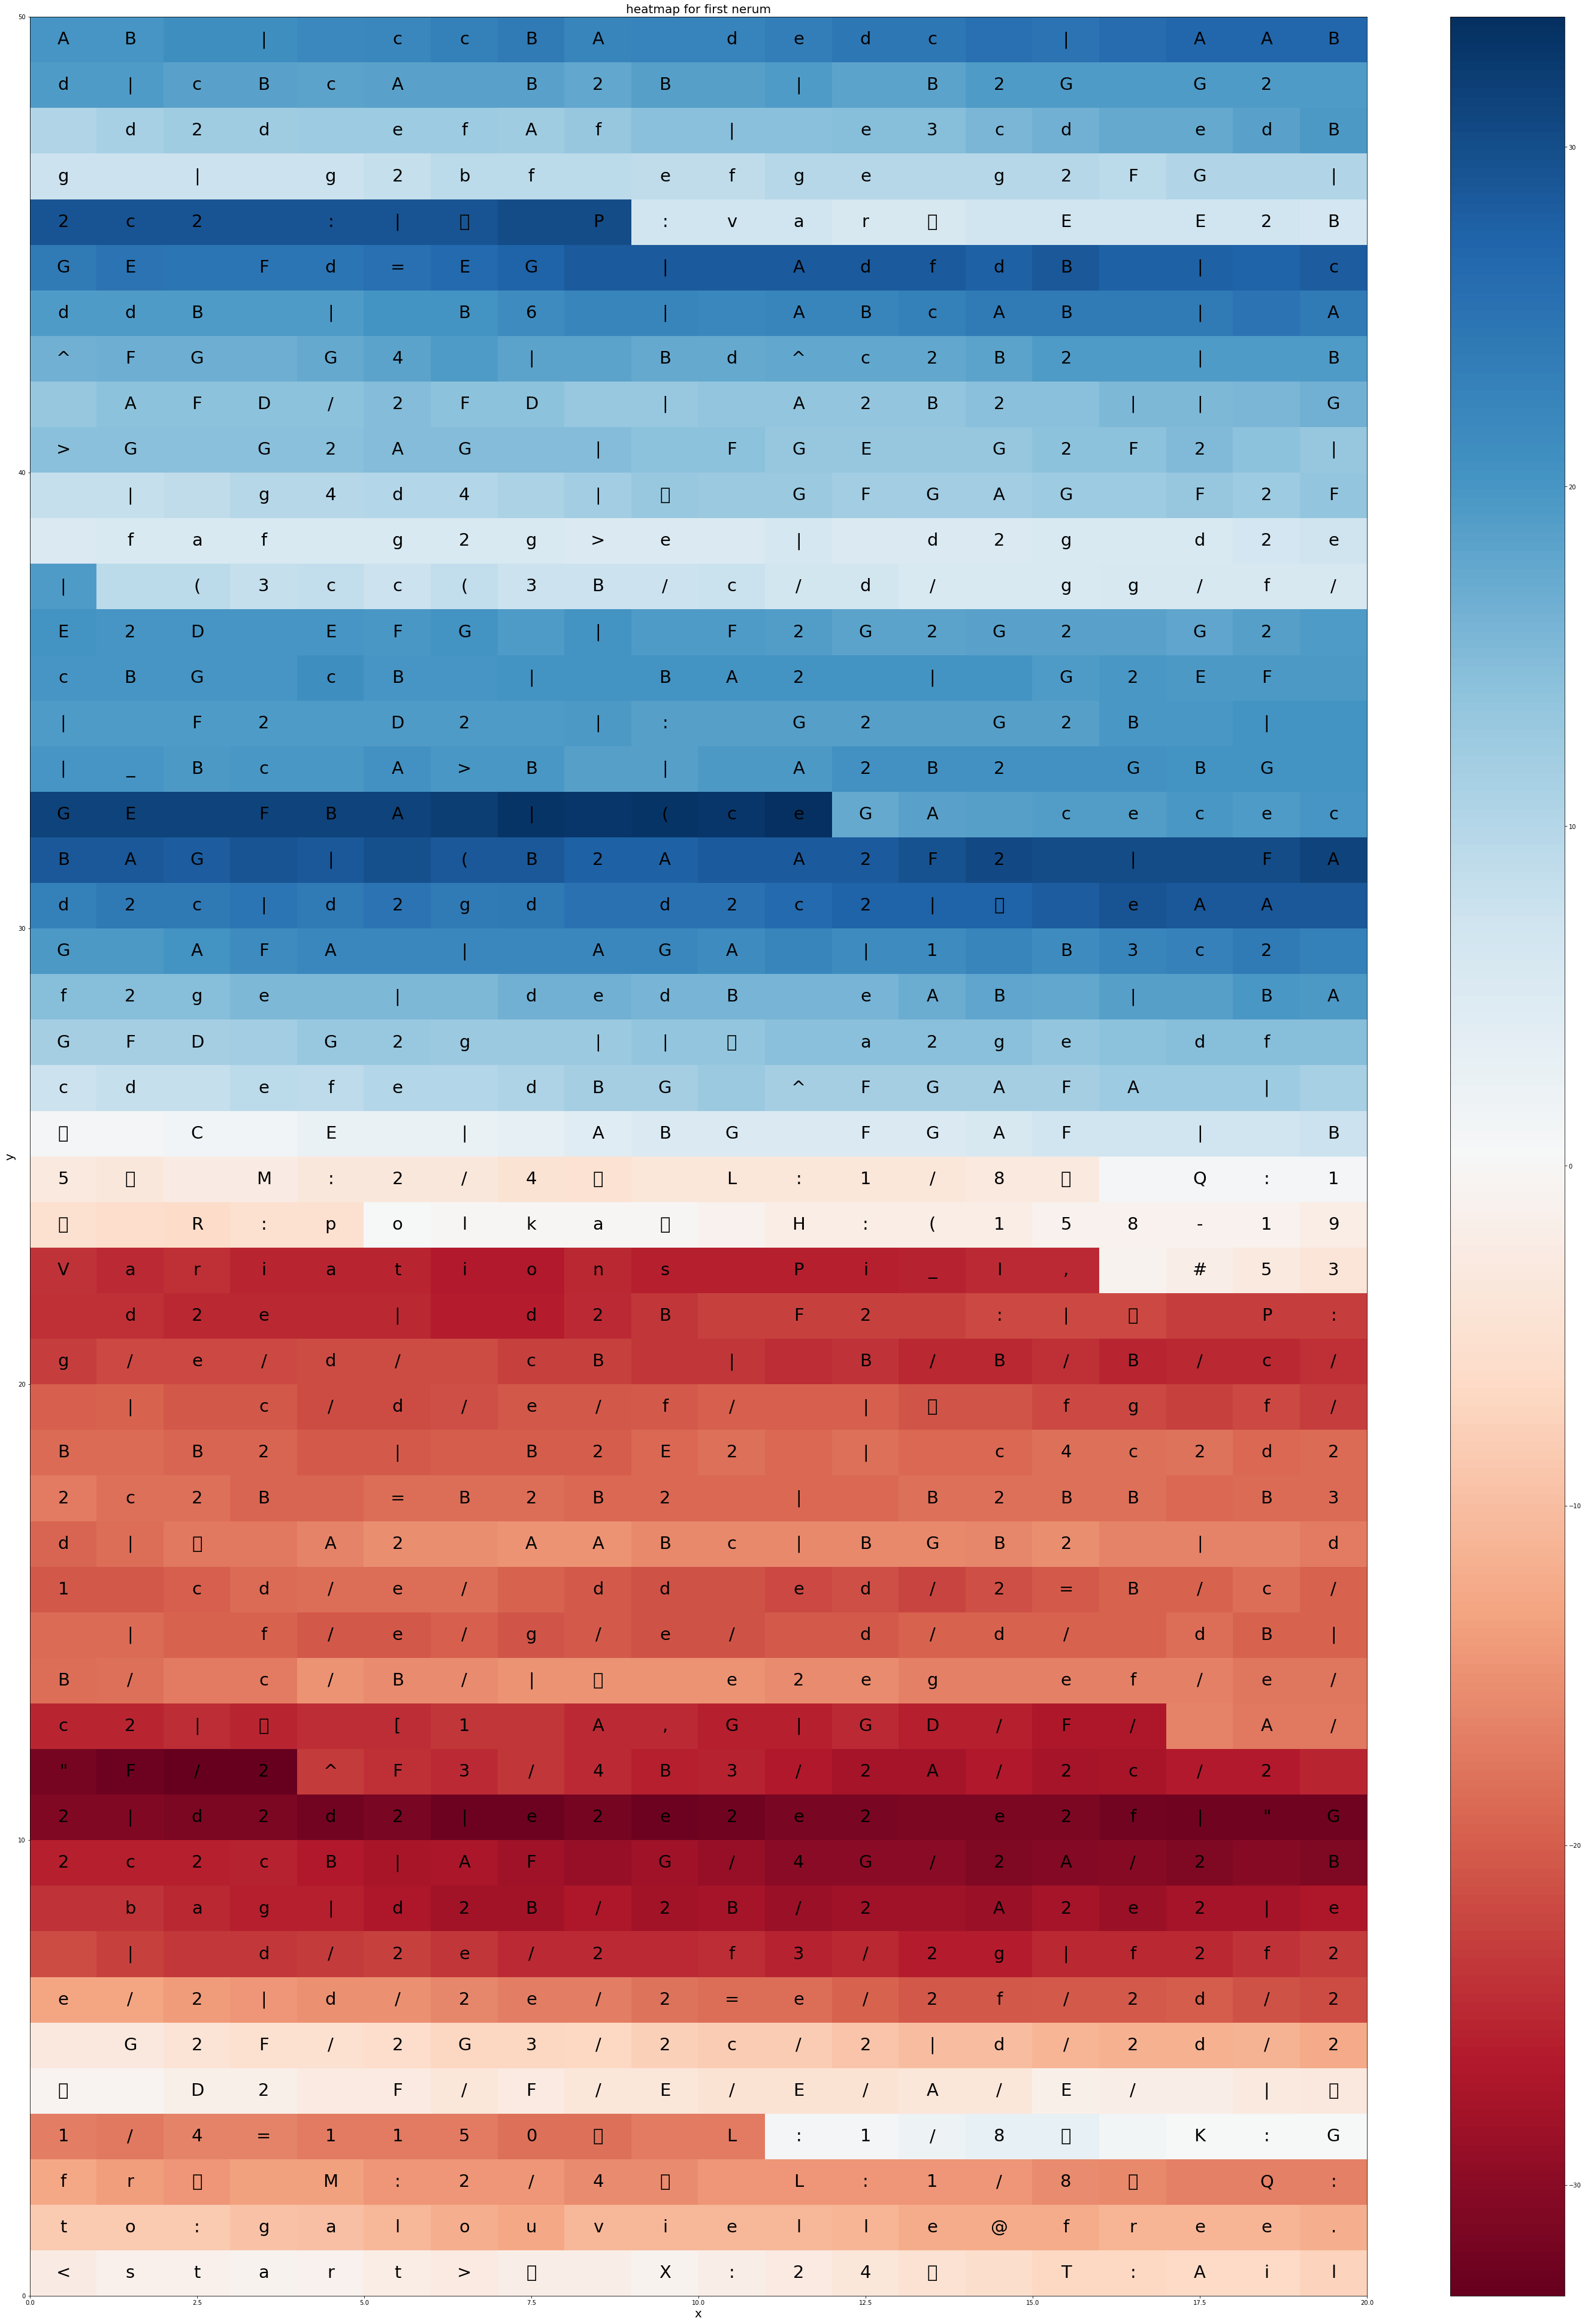

In [200]:
plot_heat(c,h_map,music_d)

In [201]:
print(music)

<start>
X:24
T:Ailto:galouvielle@free.fr
M:2/4
L:1/8
Q:1/4=1150
L:1/8
K:G
D2 F/F/E/E/A/E/ |
G2F/2G3/2c/2|d/2d/2e/2|d/2e/2=e/2f/2d/2 | d/2e/2 f3/2g|f2f2 bag|d2B/2B/2 A2e2|e2c2cB|AF G/4G/2A/2 B2|d2d2|e2e2e2 e2f|"G"F/2^F3/4B3/2A/2c/2 c2|
[1 A,G|GD/F/ A/B/ c/B/|
e2eg ef/e/ | f/e/g/e/ d/d/ dB|1 cd/e/ dd ed/2=B/c/d|
A2 AABc|BGB2 | d2c2B =B2B2 | B2BB B3B B2 | B2E2 | c4c2d2 | c/d/e/f/ |
fg f/g/e/d/ cB | B/B/B/c/ d2e | d2B F2 :|
P:Variations Pi_I, #53
R:polka
H:(158-195
M:2/4
L:1/8
Q:1
C E | ABG FGAF | Bcd efe dBG ^FGAFA | GFD G2g ||
a2ge df f2ge | dedB eAB | BAG AFA | AGA |1 B3c2 d2c|d2gd d2c2|
eAA BAG | (B2A A2F2 | FAGE FBA | (ceGA cecec|_Bc A>B | A2B2 GBG | F2 D2 |: G2 G2B | cBG cB | BA2 | G2EF E2D EFG | F2G2G2 G2 | (3cc(3B/c/d/ gg/f/ faf g2g>e | d2g d2e | g4d4 |
GFGAG F2F>G G2AG | FGE G2F2 | AFD/2FD | A2B2 || G^FG G4 | Bd^c2B2 | BddB | B6 | ABcAB | AGE Fd=EG | AdfdB | c2c2 :|
P:var
E E2Bg | g2bf efge g2FG | d2d efAf | e3cd edBd|cBcA B2B | B2G G2 AB | ccBA dedc | AABc A4 B3
